### Теперь посчитаем $\Sigma_{Н2}$ по-другому

Есть [статья](https://arxiv.org/pdf/1212.1208.pdf), в которой была найдена "карта" $\alpha_{CO}$

$\alpha_{CO}$ - это коэффициент перехода из $I_{CO}$ в $\Sigma_{H2}$

In [2]:
from IPython.display import Image
from wand.image import Image as WImage
import os
from PIL import Image as Im
import numpy as np
%pylab
%matplotlib inline
%run ./load_notebook.py

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [39]:
import functions

importing Jupyter notebook from functions.ipynb
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


Рисунок 31 из статьи

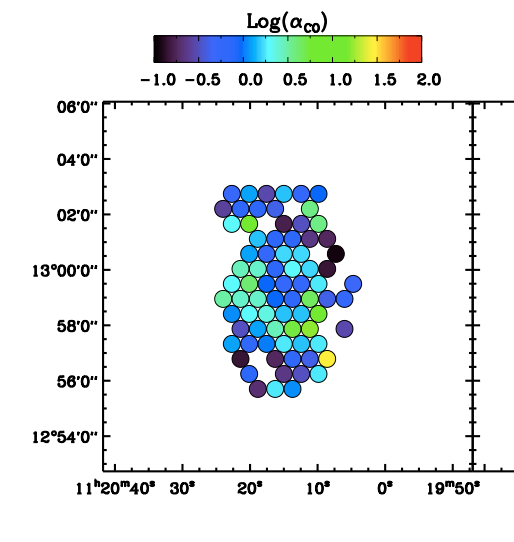

In [3]:
Image('./images/factor1.png')

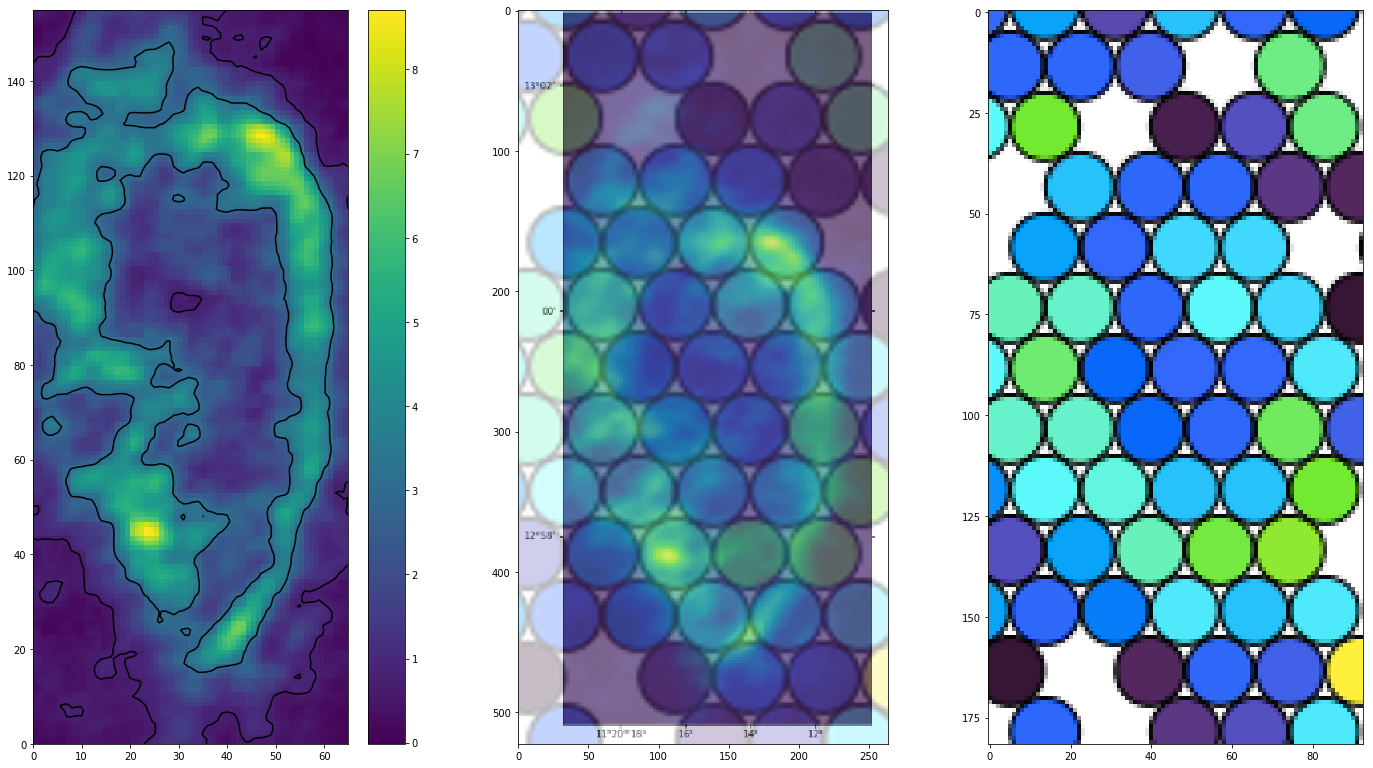

In [23]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
Sigma_HI = np.load('./data/Sigma_HI.npy')
plt.figure(figsize=[24, 13.5])
plt.subplot(1,3,1)
CS = plt.contour(X, Y, Sigma_HI, levels=[0.75,3.05], aspect='auto', alpha=1, colors='black')
quadmesh = plt.pcolormesh(X, Y, Sigma_HI)
#quadmesh.set_clim(vmax = -14.3)
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(Im.open('./images/galaxy2.png'))
plt.subplot(1,3,3)
plt.imshow(Im.open('./images/factor.png'))
plt.show()

Попробуем нарисовать примерную карту для $\alpha_{CO}$. 
На среднем рисунке я сопоставила две карты для $\Sigma_{HI}$ и $\log{\alpha_{CO}}$ покоординатно.
Можно заметить, что среднее значение $\log{\alpha_{CO}}$ на спиральных рукавах оно будет положительно и примерно равно $0.75$, а центре это значение примерно равно $-0.25$. А для пикселей кокраям рисунка будем наш коэффициент считать как раньше ($5.5 cos i$) 


In [45]:
incl = 62.
cosi = np.cos(incl / 180. * np.pi)
a_CO = np.zeros(Sigma_HI.shape)
for i, row in enumerate(Sigma_HI):
    for j, col in enumerate(Sigma_HI[0]):
        if (Sigma_HI[i][j] < 0.6):
            a_CO[i][j] = 5.5 * cosi
        if (0.6 <= Sigma_HI[i][j] < 3.05): 
            a_CO[i][j] = np.power(10, -0.25 ,dtype = np.float)
        if (3.05 <= Sigma_HI[i][j]): 
            a_CO[i][j] = np.power(10, 0.75 ,dtype = np.float)    

Теперь посчитаем $\Sigma_{H2}$ с помощью этого коэффициента

In [46]:
Sigma_H2 = np.load('./data/Sigma_H2.npy')
I_CO = np.zeros(Sigma_H2.shape)
I_CO = Sigma_H2 / 5.5 / cosi
Sigma_H2_mod = np.zeros(Sigma_H2.shape)
Sigma_H2_mod = I_CO * a_CO

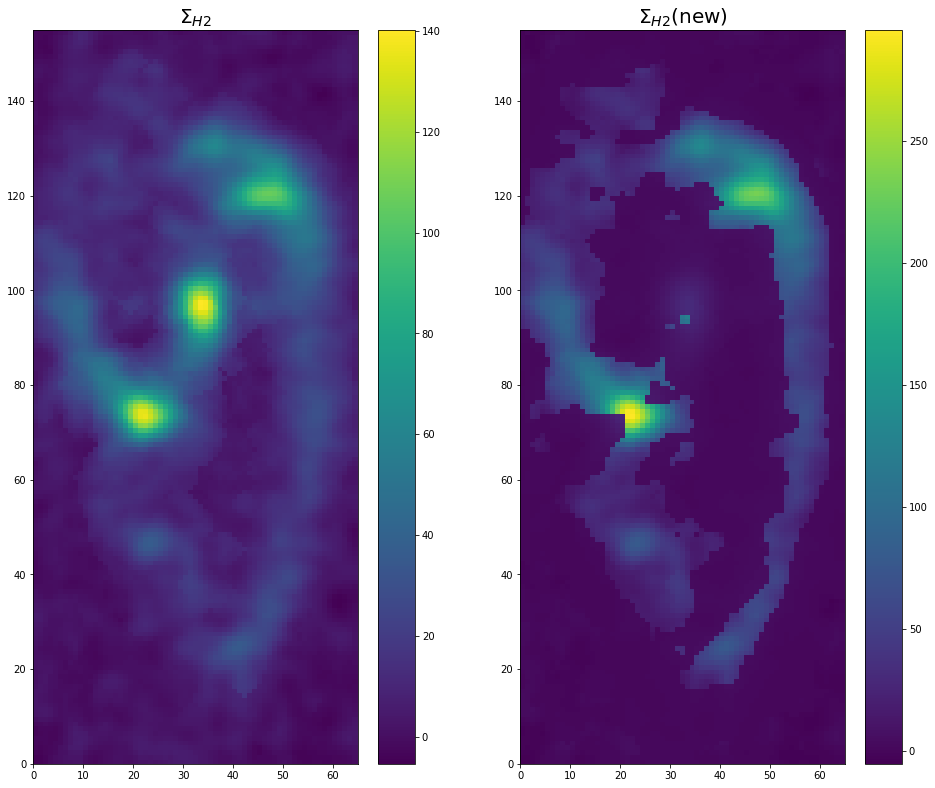

In [47]:
plt.figure(figsize=[16, 13.5])
plt.subplot(1,2,1)
quadmesh = plt.pcolormesh(X, Y, Sigma_H2)
plt.colorbar()
plt.title('$\Sigma_{H2}$', fontsize = 20)
plt.subplot(1,2,2)
quadmesh = plt.pcolormesh(X, Y, Sigma_H2_mod)
plt.colorbar()
plt.title('$\Sigma_{H2}$(new)', fontsize = 20)
plt.show()

In [48]:
sigma_s = np.load('./data/sigma_s.npy')
Sigma_H2 = np.load('./data/Sigma_H2.npy')
sigma_HI = np.load('./data/sigma_HI.npy')
Sigma_HI = np.load('./data/Sigma_HI.npy')
Sigma_s = np.load('./data/Sigma_s.npy')
sig_R_max = np.load('./data/sig_R_max.npy')
sig_R_min = np.load('./data/sig_R_min.npy')
r_HI = np.load('./data/r_HI.npy')
vel_HI = np.load('./data/vel_HI.npy')
kappa = np.load('./data/kappa.npy')
dist_kpc = np.load('./data/dist_kpc.npy')
H_alpha = np.load('./data/H_alpha.npy')

In [49]:
velocity_approx = poly1d(polyfit(r_HI, vel_HI, deg=4))

In [50]:
Distance = 9.3 # Mpc
dR =(Distance*1000*2*np.pi)/(360*60*60.)
G = 4.32
Qeff_max_mod = np.zeros(dist_kpc.shape)
Qeff_min_mod = np.zeros(dist_kpc.shape)
bark_mod = np.zeros(dist_kpc.shape)
bark_max_mod = np.zeros(dist_kpc.shape)
Qg_mod = np.zeros(dist_kpc.shape)
Qs_min = np.zeros(dist_kpc.shape)
Qs_max = np.zeros(dist_kpc.shape)
Sigma_g = np.zeros(dist_kpc.shape)

step = 0
errors = 0
for i, row in enumerate(dist_kpc):
    for j, col in enumerate(dist_kpc[0]):
        step+=1
        if step % 1000 == 0:
            print(step)
        c = sigma_HI[i][j]/1000.
        Sigma_g[i][j] = 1.36*(Sigma_HI[i][j] + Sigma_H2_mod[i][j])
        kappa = functions.epic_freq(velocity_approx, dist_kpc[i][j], dR)
        Sigma_s_ = Sigma_s[i][j]
        s_R_max = sig_R_max[i][j]
        s_R_min = sig_R_min[i][j]
        Qg_mod[i][j] = kappa * c / (math.pi * G * Sigma_g[i][j])
        Qs_max[i][j] = kappa * s_R_max / (3.36 * G * Sigma_s_)
        Qs_min[i][j] = kappa * s_R_min / (3.36 * G * Sigma_s_)
        
       
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_min[i][j], Qg=Qg_mod[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_min_mod[i][j] = 1./qeff
        bark_mod[i][j] = root_for_max
        
        try:
            root_for_max, qeff = functions.FindMaxQeffKinem(rangek=np.arange(0.01, 50., 1.), Qs=Qs_max[i][j], Qg=Qg_mod[i][j], s=c/s_R_min)
        except ValueError:
            errors+=1
            qeff = 0.01
            root_for_max = -1.
        Qeff_max_mod[i][j] = 1./qeff
        bark_max_mod[i][j] = root_for_max
        
print('Errors:{}'.format(errors))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Errors:4704


In [51]:
Qeff_min = np.load('./data/Qeff_min.npy')
Qeff_max = np.load('./data/Qeff_max.npy')


Text(0.5, 1.0, '$Q_{eff}^{min}$(new)')

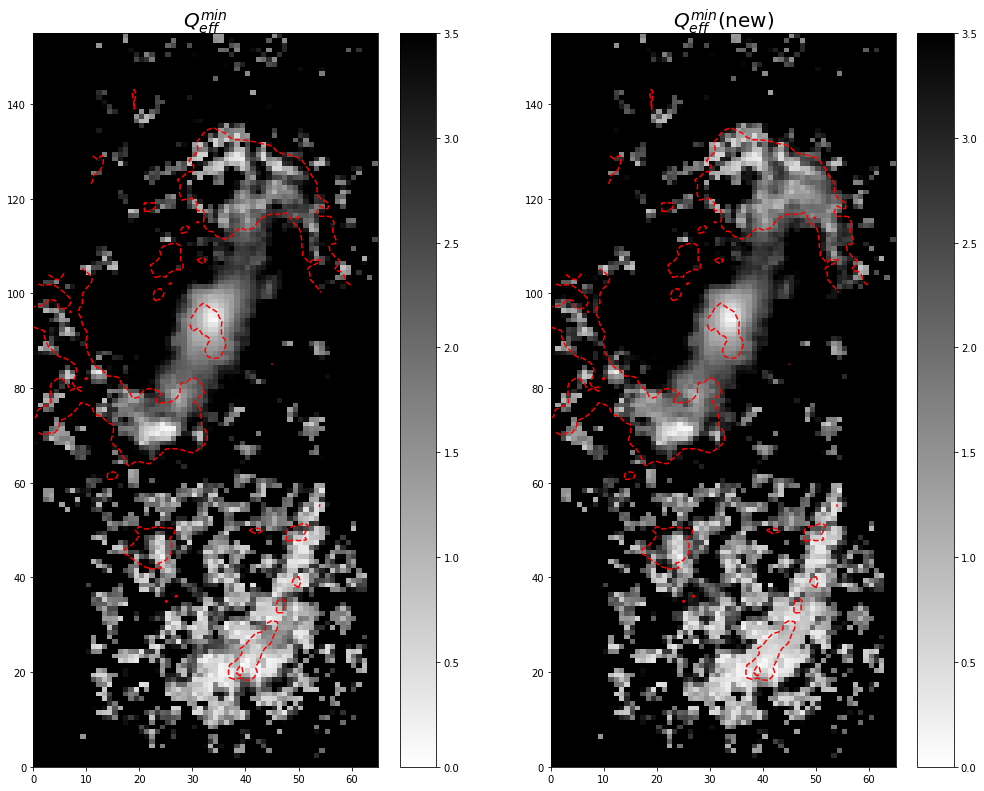

In [52]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_min_mod, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{min}$(new)', fontsize=20)

Text(0.5, 1.0, '$Q_{eff}^{max}$(new)')

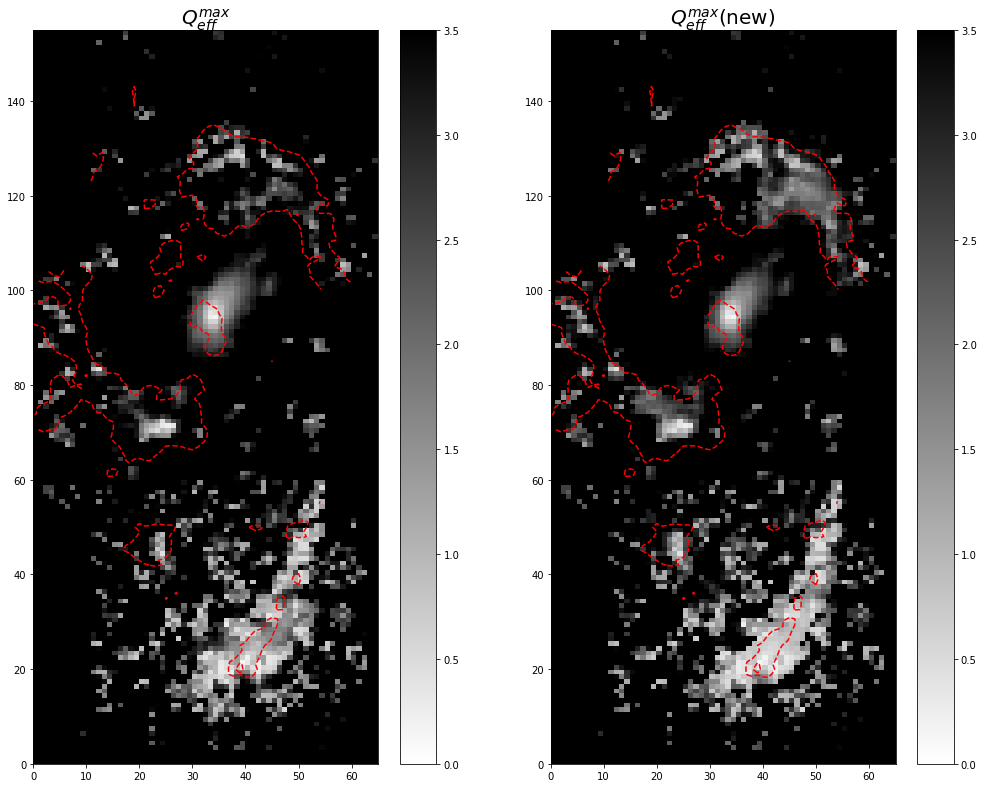

In [53]:
X,Y = np.meshgrid(np.arange(0.,66,1), np.arange(0.,156,1))
plt.figure(figsize=[17, 13.5])
plt.subplot(1,2,1)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$', fontsize=20)

plt.subplot(1,2,2)
CS = plt.contour(X, Y, np.log10(H_alpha), levels=[-14.2,-12], aspect='auto', alpha=1, colors='red')
quadmesh = plt.pcolormesh(X, Y, Qeff_max_mod, cmap='gist_yarg')
quadmesh.set_clim(vmin=0., vmax=3.5)
quadmesh.cmap.set_under('white')
plt.colorbar()
plt.title(r'$Q_{eff}^{max}$(new)', fontsize=20)